# Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import time
import random
# import gc
# import pyarrow as pa
# import pyarrow.parquet as pq
# import pickle
# import sys
import warnings
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import integrate 
import scipy
import math
# import seaborn as sns
# import statistics
# import robustats
# import pgeocode
# import folium
# from folium import plugins
# from itertools import repeat
# from sklearn import preprocessing
import functools

warnings.filterwarnings("ignore")

# Functions

In [2]:
def u(t,power):
    if (t >= T) or (t < L):
        return 1
    else:
        return (t/T)**power

In [3]:
def derivs(initial_state, t, N, contact_rate, recovery_rate, reinfection_rate,power):
    S, I, R = initial_state
    dSdt = u(t,power) * (-contact_rate * I * S)  + (R * reinfection_rate)
    dIdt = u(t,power) * (contact_rate * I * S) - (recovery_rate * I)
    dRdt = u(t,power) * (recovery_rate * I) - (R * reinfection_rate)

    return(dSdt,dIdt,dRdt)

def plot(power):
    # Integrate the SIR equations over the time grid, t.
    solution = odeint(derivs, initial_state, t, args=(N, contact_rate, recovery_rate, reinfection_rate,power))

    plt.figure(figsize=(12,5))
    plt.plot(t, solution[:, 0], 'b', label='S(t)')
    plt.plot(t, solution[:, 1], 'r', label='I(t)')
    plt.plot(t, solution[:, 2], 'g', label='R(t)')
    plt.legend(loc='best',prop={'size': 15})
    plt.xlabel('months')
    plt.ylabel('proportion of population')
    plt.grid()
    plt.show()
    
    print("u(t) = (t/T)**"+str(power))
    print("The max of I(t) is \033[1m"+str(round(max(solution[:, 1]),3))+"\033[0m on day", 
          solution[:, 1].tolist().index(max(solution[:, 1])))
    
    ys = solution[:, 1]
    xs = np.array(t)
    print("Area under I(t) is \033[1m"+str(round(scipy.integrate.simps(ys,xs),3))+" \033[0munits sq")
    
def optimize(power):
    solution = odeint(derivs, initial_state, t, args=(N, contact_rate, recovery_rate, reinfection_rate,power))
    ys = solution[:, 1]
    xs = np.array(t)
    return(max(solution[:, 1]),scipy.integrate.simps(ys,xs))

def cycle(start,end,step):
    
    powers=np.arange(start,end,step)
    big_list = []
    for power in powers:
        l = []
        l.append(power)
        l.append(optimize(power)[0])
        l.append(optimize(power)[1])
        big_list.append(l)
    big_list

    return pd.DataFrame(columns=['(t/T)**power','Peak','Area'],data=[i for i in big_list])


# Parameters

In [4]:
r0 = 3.28# rate of reproduction
recovery_rate = 1 # the proportion of infected recovering per day 
contact_rate = r0 * recovery_rate # expected amount of people an infected person infects per day
reinfection_rate = 0.14

L = 1 # day when we start full lockdown
T = 7 # day when we completely lift lockdown

N = 25518568 #population of AUS
S0 = 25518000/N #initial susceptible 
I0 = 568/N #initial infected
R0 = 1 - S0 - I0 #initial recovered

initial_state = S0, I0, R0
t=np.arange(0,24) #time grid
months = t.size

# Modelling and Plotting

In [5]:
result = cycle(start=0, end=5, step=0.01)

In [6]:
pd.set_option("display.max_rows",10)
result = result.sort_values(['Peak'],ascending=True).reset_index(drop=True)
best = result.at[0,'(t/T)**power']
result.head()

,(t/T)**power,Peak,Area
0,0.25,0.295561,2.044890
1,0.26,0.296919,2.041491
2,0.49,0.300709,1.982452
3,0.50,0.300855,1.980266
4,0.27,0.301313,2.038180


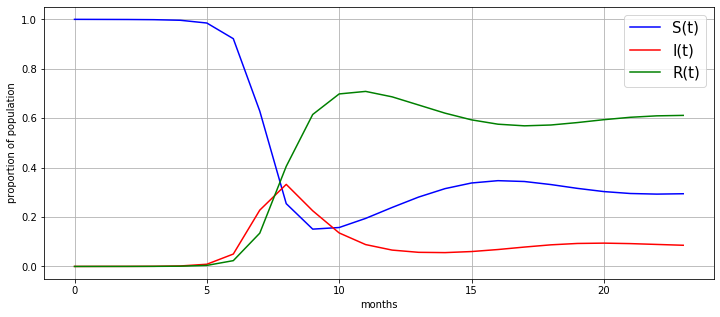

u(t) = (t/T)**0.6
The max of I(t) is 0.332 on day 8
Area under I(t) is 1.958 units sq


In [7]:
plot(0.60)

# Simulated Annealing

In [32]:
def derivs2(initial_state, t, N, contact_rate, recovery_rate, reinfection_rate,x):
    S, I, R = initial_state
    dSdt = u_annealing(t,x) * (-contact_rate * I * S)  + (R * reinfection_rate)
    dIdt = u_annealing(t,x) * (contact_rate * I * S) - (recovery_rate * I)
    dRdt = u_annealing(t,x) * (recovery_rate * I) - (R * reinfection_rate)

    return(dSdt,dIdt,dRdt)

def peak(X):
    solution = odeint(derivs2, initial_state, t, args=(N, contact_rate, recovery_rate, reinfection_rate,X))
    return max(solution[:, 1])

def u_annealing(t,x):
    return x[int(t)]

# def area(X):
#     solution = odeint(derivs, initial_state, t, args=(N, contact_rate, recovery_rate, reinfection_rate))
#     ys = solution[:, 1]
#     xs = np.array(t)
#     return(scipy.integrate.simps(ys,xs))
 
def random_neighbour(X, fraction=1):
    interval = (0, 1)
    amplitude = (max(interval) - min(interval)) * fraction / 10

    for i in range(months):
        delta = (-amplitude/2.) + amplitude * np.random.random_sample()
        X[i] +=  delta
        if X[i] <0:
            X[i] = 0.01
        if X[i] >1:
            X[i] = 1
    
    for i in range(0,L):
        X[i] = 1
    for i in range(T,months):
        X[i] = 1
        
    return (X)
    
def annealing(search_space,func,T,n):
    t = T
    x=search_space
    E = func(x)
    history=[x]    
    for i in range(n):
        new = random_neighbour(x)
        if func(new) - E < 0 or math.e**(-(func(new) - E)/t) > random.uniform(0, 1):
            x = new
            E = func(x)
        history.append(x)
        t = t * 0.9
        
    ###plotting###
#     xs = np.array(history)
#     ys = []
#     x2 = []
#     count = 0
#     for i in xs:
#         count+=1
#         x2.append(count)
#         ys.append(peak(i))
#     ys = np.array(ys)
#     plt.plot(xs,ys)
    
    print("Smallest peak =",func(x),'for array:',x)
    return (x)

In [33]:
t=np.arange(0,24) #time grid

In [34]:
X = np.linspace(0,1,granularity)
for i in range(X.size):
    if i < L or i >= T:
        X[i] = 1
X

array([1.        , 0.04347826, 0.08695652, 0.13043478, 0.17391304,
       0.2173913 , 0.26086957, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

In [35]:
r = annealing(X,peak,1,1000)

Smallest peak = 0.31153070043174336 for array: [1.         0.62440646 0.7293121  0.09322055 0.97876788 0.74867925
 0.74417878 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.        ]


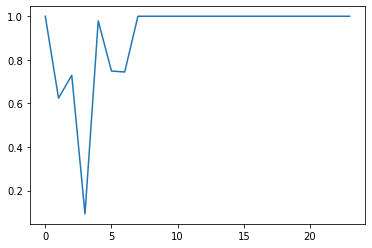

In [36]:
plt.plot(t,r)